# Simulation of a Prescribed Fire policy 

In [1]:
%load_ext autoreload
%autoreload 2

In [192]:
import os

import duckdb
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from prescribed.estimate.simulations import (
    make_model,
    make_predictions,
    run_simulations,
    sample_rx_years,
    simulation_data,
)
from prescribed.plot import template_plots
from prescribed.utils import prepare_template

# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Noto Mono"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

In [3]:
policy_size = 1_000_000
size_rx = 1_000

print(f"Number of policy 1 sq-km pixels: {policy_size / 247.105}")
print(
    f"If all fires are of {size_rx} acres, then the size is: {size_rx / 247.105} sq-km"
)
print(f"Number of fires in the policy area: {policy_size / size_rx}")

Number of policy 1 sq-km pixels: 4046.8626697153036
If all fires are of 1000 acres, then the size is: 4.046862669715304 sq-km
Number of fires in the policy area: 1000.0


In [4]:
sim_data = simulation_data(
    template="/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif",
    land_type="/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather",
    roads=[
        "/mnt/sherlock/oak/prescribed_data/raw/os_roads_ca/norcal/gis_osm_roads_free_1.shp",
        "/mnt/sherlock/oak/prescribed_data/raw/os_roads_ca/socal/gis_osm_roads_free_1.shp",
    ],
    only_roads=False,
    buf=10_000,
    road_type="secondary",
)

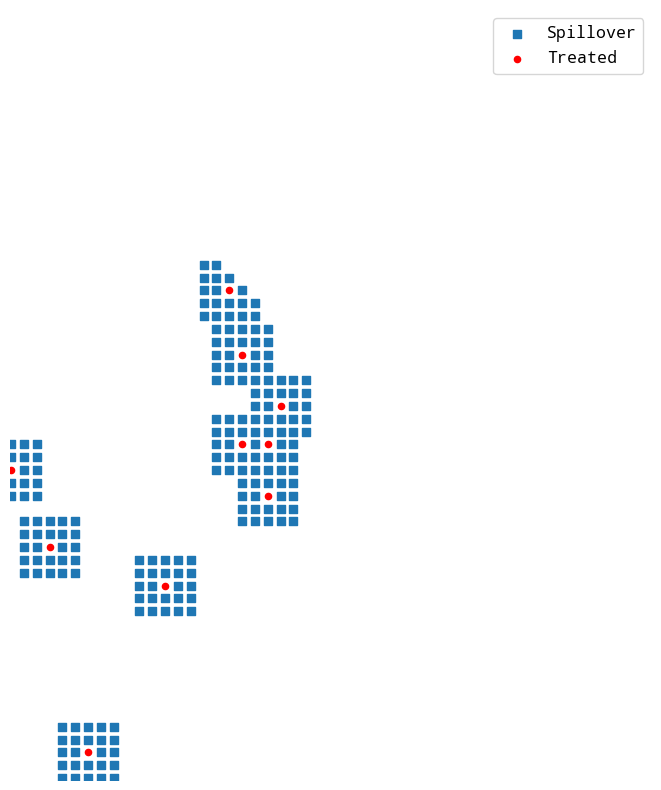

In [ ]:
# Sim data as a geodataframe
sim_data = gpd.GeoDataFrame(
    sim_data, geometry=gpd.points_from_xy(sim_data.lon, sim_data.lat)
)
sim_data = sim_data.set_crs(epsg=3310)

# Get a sample of the points
sim_data_sample = sim_data[
    (sim_data["land_type"] == 2)
    & (sim_data.lon > 50000)
    & (sim_data.lon < 100000)
    & (sim_data.lat > 10000)
    & (sim_data.lat < 70000)
].sample(10)

# Transform to geopandas and then buffer the points
sim_data_gpd = gpd.GeoDataFrame(
    sim_data_sample,
    geometry=gpd.points_from_xy(sim_data_sample.lon, sim_data_sample.lat),
)
sim_data_gpd = sim_data_gpd.set_crs(epsg=3310)


# Buffer the points to 5 km
sim_data_gpd["geometry"] = sim_data_gpd.buffer(2000, cap_style="square")


# Filter points that overlap with the buffered points
sample_complete = sim_data.overlay(
    sim_data_gpd.drop(columns=["lat", "lon", "grid_id"], errors="ignore"),
    how="intersection",
)

sample_complete = sample_complete.drop_duplicates(subset=["grid_id"])

sample_complete = sample_complete[
    ~sample_complete.grid_id.isin(sim_data_sample.grid_id)
]

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

sample_complete.plot(ax=ax, marker="s")

# Plot sampled points
sim_data_sample.plot.scatter(x="lon", y="lat", ax=ax, color="red")

# Plot the buffered points
# sim_data_gpd.plot(ax=ax, color="red", alpha=0.5)

# Set limits of the plot
ax.set_xlim(50000, 100000)
ax.set_ylim(10000, 70000)

# Apply template
template_plots(ax, no_axis=True, xlab="", ylab="")

# Add a legend to the plot to have red squares with transparency for buffers, red squared for treated and blue squares for untreated
ax.legend(["Spillover", "Treated"], loc="upper right")


# Save the plot
plt.savefig("../figs/spillovers_test.png", dpi=300, bbox_inches="tight")

In [ ]:
# Prepare results
results = pd.read_csv("../data/results/att_conifers_dnbr.csv")
results["land_type"] = results.land_type.replace(
    {"conifers": 2.0, "shrublands": 12.0}
)

spillover_results = pd.read_csv("../data/results/att_spillover.csv")
spillover_results = (
    spillover_results[spillover_results.dist_treat == 2000]
    .drop(columns="dist_treat", errors="ignore")
    .sort_values("year")
)

spillover_results = spillover_results[spillover_results.year <= 7]

sim_data = sim_data[sim_data.land_type.isin([2])]

# Prepare fire data
fire_data = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/treatments_mtbs.feather"
).drop(columns=["spatial_ref"], errors="ignore")
fire_data = fire_data[fire_data.year >= 2010]

# Prepare template
template = prepare_template(
    "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif",
    years=[2000, 2022],
)
template = template[template.year >= 2010]

In [ ]:
test_sample = sample_rx_years(
    template=template,
    treat_data=sim_data,
    fire_data=fire_data,
    estimates=results,
    size_treatment=1_000,
    spillovers=True,
    spillover_size=2_000,
    spillover_estimates=spillover_results,
    start_year=2020,
    sample_n=1000,
)

Sampling years:  33%|███▎      | 1/3 [00:00<00:00,  7.92it/s]

0
20534


40867


In [ ]:
run_simulations(
    template=template,
    sim_data=sim_data,
    results=results,
    fire_data=fire_data,
    save_path="../data/sims_number_no_spill/",
    num_sims=100,
    step_save=10,
    size_treatment=1_000,
    start_year=2010,
    sample_n=10,
    crs="EPSG:3310",
    format="parquet",
    spillovers=False,
    spillover_size=2_000,
    spillover_estimates=spillover_results,
)

Grouping simulations:   0%|          | 0/10 [00:00<?, ?it/s]

Grouping simulations: 100%|██████████| 10/10 [03:09<00:00, 18.97s/it]


### Plot animation of treatment 

In [ ]:
test_sim = duckdb.query(
    """
select year_treat, count(distinct grid_id) as num_treated
from '../data/policy_spill_100/*.parquet'
where sim == 1
group by year_treat
"""
).to_df()

In [39]:
test_sim

,year_treat,num_treated
0,2010,2137
1,2014,2075
2,2015,2066
3,2018,1960
4,2012,2095
5,2020,2096
6,2011,1952
7,2016,2149
8,2021,2077
9,2013,2163


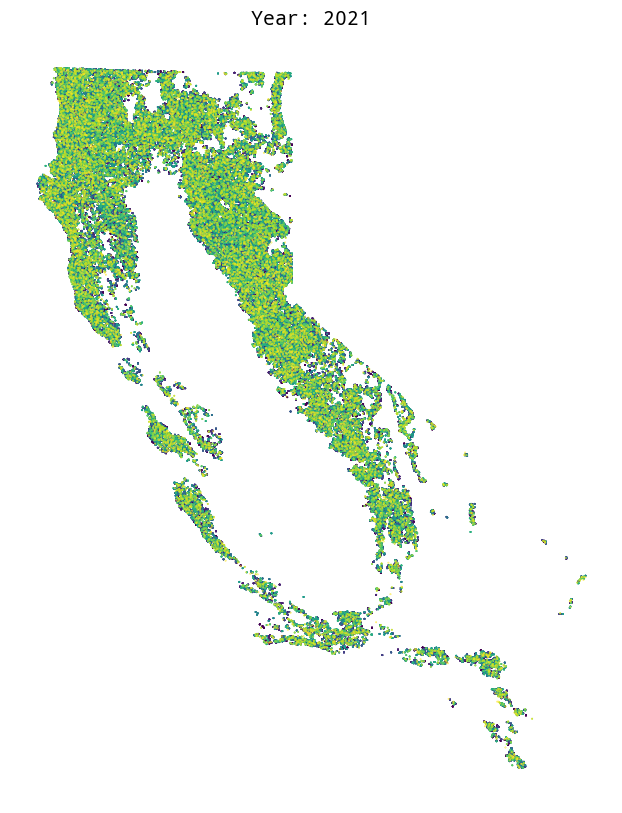

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming test_sim is already defined and is a GeoDataFrame
# test_sim = gpd.GeoDataFrame(...)  # Your GeoDataFrame initialization

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Set limits of the plot
# ax.set_xlim(-400_000, -300_000)
# ax.set_ylim(200_000, 400_000)

# Remove axis
ax.axis("off")

# Get unique years
years = sorted(test_sim["year_treat"].dropna().unique())


# Define the update function
def update(year):
    ax.clear()
    # ax.set_xlim(-400_000, -300_000)
    # ax.set_ylim(200_000, 400_000)
    ax.axis("off")
    test_sim[test_sim["year_treat"] <= year].plot(
        ax=ax, column="year_treat", legend=False, s=0.1
    )
    ax.set_title(f"Year: {year}")


# Create the animation
ani = FuncAnimation(fig, update, frames=years, repeat=False)

# Save the animation as a GIF or MP4
ani.save("animation.gif", writer="imagemagick", fps=1)
# ani.save('animation.mp4', writer='ffmpeg', fps=1)

# Display the animation
plt.show()

### Read simulations

In [5]:
# Load DNBR data and save to parquet to make it nicer for DuckDB
data_path = "/mnt/sherlock/oak/prescribed_data/"

template = prepare_template(
    os.path.join(data_path, "geoms/templates/template.tif")
)

dnbr = pd.read_feather(
    os.path.join(data_path, "processed/dnbr_gee/dnbr_long.feather")
)

land_type = pd.read_feather(
    os.path.join(data_path, "processed/land_type/land_type.feather")
)

mtbs = gpd.read_file(
    os.path.join(data_path, "geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp")
).to_crs("EPSG:3310")

# Merge it to get years
mtbs["year"] = mtbs.Ig_Date.dt.year
dnbr = dnbr.merge(
    mtbs[["Event_ID", "year"]],
    right_on="Event_ID",
    left_on="event_id",
    how="left",
)
dnbr.drop(columns=["Event_ID"], inplace=True)

# Subset and save to parquet
# dnbr = dnbr[dnbr.year >= 2010]
# dnbr["dnbr"] = np.where(dnbr.dnbr < 0, 0, dnbr.dnbr)
dnbr["low_severity"] = np.where((dnbr.dnbr <= 270) & (dnbr.dnbr > 100), 1, 0)
dnbr["high_severity"] = np.where((dnbr.dnbr > 660), 1, 0)

dnbr.to_parquet("../data/dnbr.parquet")

In [6]:
# Read in all the sims to merge with dnbr data
df = duckdb.query("""
with sim as (
SELECT lat, lon, year, year_treat, coeff, sim, land_type, grid_id
FROM '../data/policy_no_spill_4000/*.parquet') 
SELECT d.grid_id,
       d.event_id,
       d.year, 
       s.year_treat, 
       s.coeff, 
       s.sim, 
       d.dnbr,
       s.land_type,
       d.dnbr + s.coeff as sim_dnbr,
       d.low_severity,
       d.high_severity
FROM sim s
right join (SELECT grid_id, year, dnbr, low_severity, high_severity, event_id
                  FROM "../data/dnbr.parquet") as d
ON s.grid_id = d.grid_id AND s.year = d.year
""")

# Aggregated data by year and year_treat to plot
df_year_treat = duckdb.query("""
select year, year_treat, mean(coeff) as coeff_mean
from df
where year_treat is not null
group by year, year_treat
""")

# Aggregated data by year and sim to plot
df_year_treat_sim = duckdb.query("""
select year, year_treat, sim, mean(coeff) as coeff_mean
from df
group by year, sim, year_treat
""")


<Axes: xlabel='Year', ylabel='Simulated change in $\\Delta$NBR'>

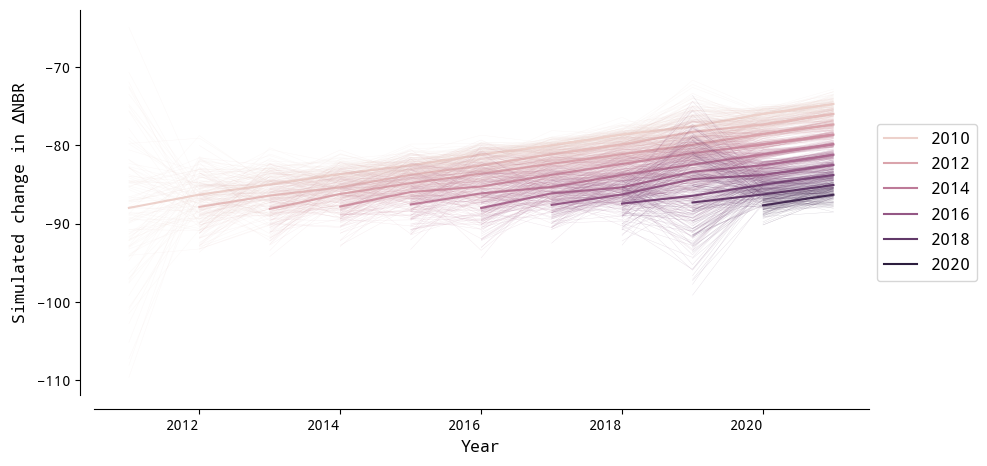

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(
    data=df_year_treat.to_df(),
    x="year",
    y="coeff_mean",
    hue="year_treat",
    ax=ax,
)

sns.lineplot(
    data=df_year_treat_sim.to_df(),
    x="year",
    y="coeff_mean",
    units="sim",
    estimator=None,
    hue="year_treat",
    legend=False,
    linewidth=0.25,
    ax=ax,
    alpha=0.2,
)

# Move legend to the right outside of the plot
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Apply template
template_plots(ax, xlab="Year", ylab=r"Simulated change in $\Delta$NBR")

# Save plot
# plt.savefig("../figs/simulations_coefs.png", bbox_inches="tight")

/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/joypy/joyplot.py:234: UserWarning: At least a column/group has no numeric values.
  warn("At least a column/group has no numeric values.")


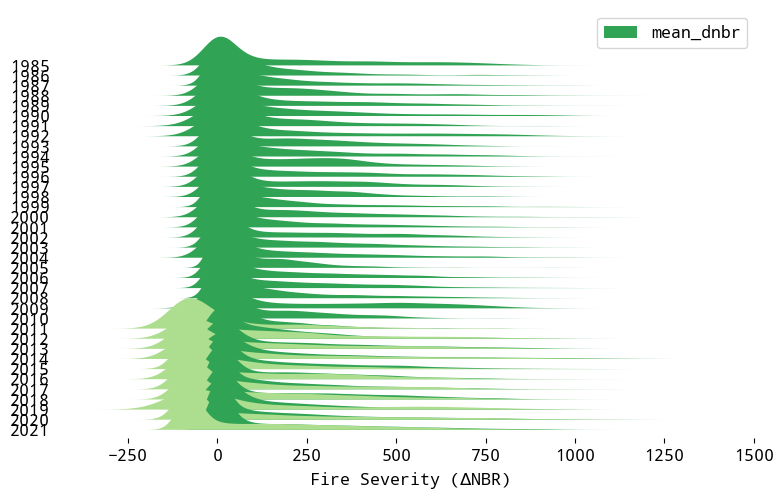

In [ ]:
import joypy

dist_state = duckdb.query("""
select year, grid_id, 
    mean(dnbr) as mean_dnbr, 
    mean(sim_dnbr) as mean_sim_dnbr
from df 
where year is not NULL
group by year, grid_id
""").to_df()

# dist_state = pd.read_csv("../data/joyplot_data.csv")

labels = [str(int(d)) for d in dist_state.year.unique()]
fig, axes = joypy.joyplot(
    dist_state,
    by="year",
    column=["mean_dnbr", "mean_sim_dnbr"],
    legend=True,
    figsize=(8, 5),
    fade=False,
    overlap=1,
    linewidth=0,
    tails=0.1,
    fill=True,
    ylim="max",
    # sublabels = ["$\Delta$NBR", "Simulated $\Delta$NBR"],
    color=["#31a354", "#addd8e"],
)

# Change axis labels
for ax in axes:
    ax.set_xlabel("Fire Severity ($\Delta$NBR)")
# Save plot
# plt.savefig("../figs/dnbr_simulated_joy.png", dpi=300, bbox_inches="tight")

### Check totals across state to calculate benefits

#### Severity 

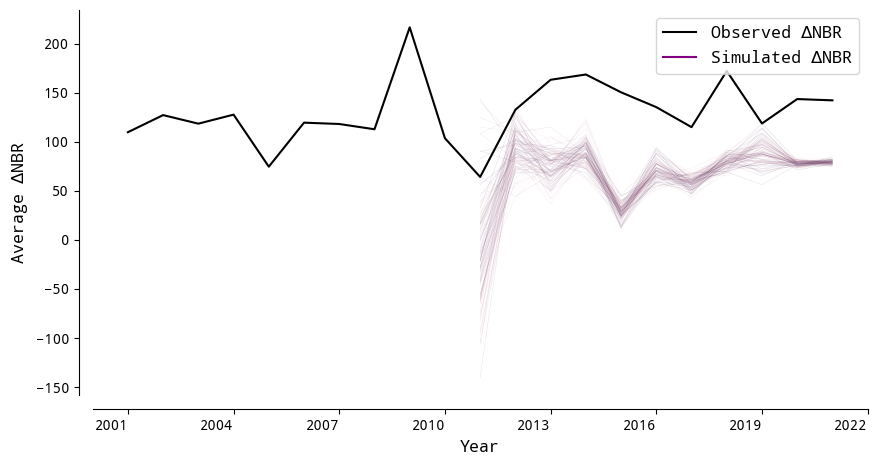

In [7]:
import matplotlib.lines as mlines
import seaborn as sns

severity_raw = duckdb.query("""
select year, 
    sum(dnbr) as sum_dnbr,
    mean(dnbr) as mean_dnbr
from '../data/dnbr.parquet'
where year > 2000
group by year
""").to_df()

severity = duckdb.query("""
with sim as (
SELECT lat, lon, year, year_treat, coeff, sim, land_type, grid_id
FROM '../data/policy_no_spill_4000/*.parquet'),
df as (
SELECT d.grid_id,
       d.year, 
       d.event_id,
       s.year_treat, 
       s.sim, 
       d.dnbr, 
       d.dnbr - abs(s.coeff) as sim_dnbr
FROM sim s
right join (SELECT grid_id, year, dnbr, event_id
            FROM "../data/dnbr.parquet") as d
ON s.grid_id = d.grid_id AND s.year = d.year),
df_sim as (
select year, 
    sim,
    mean(sim_dnbr) as sum_sim_dnbr,
from df
group by sim, year
) 
select *
from df_sim
where year > 2010
""").to_df()

# Use seaborn to plot the time series data and hue by simulation
fig, ax = plt.subplots(1, 1, figsize=(10, 5))


severity_raw.plot.line(
    x="year", y="mean_dnbr", ax=ax, label="Observed $\Delta$NBR", color="black"
)

sns.lineplot(
    data=severity,
    x="year",
    hue="sim",
    y="sum_sim_dnbr",
    linewidth=0.25,
    ax=ax,
    alpha=0.2,
    legend=False,
)

# Apply template
template_plots(ax, xlab="Year", ylab=r"Average $\Delta$NBR")

# Change x-axis labels to be integers
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Add only one label for the simulated lines
# Add custom legend entries
observed_line = mlines.Line2D(
    [], [], color="black", label="Observed $\Delta$NBR"
)
simulated_line = mlines.Line2D(
    [], [], color="purple", label="Simulated $\Delta$NBR"
)
ax.legend(handles=[observed_line, simulated_line], loc="upper right")


# Save plot
plt.savefig("../figs/simulated_severity.png", bbox_inches="tight")


#### Emissions

In [217]:
df = duckdb.query("""
WITH cross_product AS (
    SELECT d.*, s.sim
    FROM (
        SELECT * FROM '../data/dnbr.parquet'
        WHERE year >= 2010
    ) AS d
    CROSS JOIN (
        SELECT range AS sim
        FROM range(100)
    ) AS s
),
sim AS (
    SELECT lat, lon, year, year_treat, coeff, sim, land_type, grid_id
    FROM '../data/policy_no_spill_4000/*.parquet'
)
SELECT d.grid_id,
    d.year, 
    d.event_id,
    s.year_treat, 
    s.coeff, 
    d.sim, 
    d.dnbr, 
    s.land_type,
    d.dnbr + coalesce(s.coeff, 0) as sim_dnbr
FROM sim s
RIGHT JOIN cross_product AS d
ON s.grid_id = d.grid_id AND s.year = d.year AND s.sim = d.sim
""")

sim_severity = duckdb.query("""
with year_agg as (
select event_id,
        year,                            
        sim, 
        sum(dnbr) as sum_dnbr,
        sum(sim_dnbr) as sum_sim_dnbr,
from df
group by sim, event_id, year
)
select * from year_agg
""").to_df()

sim_severity


,event_id,year,sim,sum_dnbr,sum_sim_dnbr
0,CA4126812300220140731,2014,1,47096.035250,43870.235593
1,CA4179612337420140814,2014,1,166134.237232,154499.913733
2,CA4042012272920140711,2014,1,9515.098753,9363.037521
3,CA3859811975220150620,2015,1,18165.836988,16358.255970
4,CA4060412308120150731,2015,1,6555.579637,5969.009922
...,...,...,...,...,...
52095,CA4018412336320170808,2017,24,2108.039409,2108.039409
52096,CA4018412336320170808,2017,40,2108.039409,2108.039409
52097,CA4018412336320170808,2017,43,2108.039409,2108.039409
52098,CA4018412336320170808,2017,45,2108.039409,2108.039409


In [222]:
smoke_linked = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked.feather"
)

coefs = make_model(
    smoke_linked[smoke_linked.coverage_threshold == 0.5],
    formula="sum_contrib ~ sum_severity + I(sum_severity**2) + total_days + total_pixels",
    fe=True,
)

# Merge liked data and only estimate over the same fires we matched
sim_severity_merge = sim_severity.merge(
    smoke_linked[smoke_linked.coverage_threshold == 0.5],
    on=["event_id", "year"],
)

In [207]:
# Estimate boostrap confidence intervals

# Range of severities
range_severity = np.arange(
    smoke_linked["sum_severity"].min(),
    smoke_linked["sum_severity"].max(),
    100,
)


boot_samples = []
for _ in tqdm.tqdm(range(100), desc="Bootstrapping"):
    # Sample with replacement
    sample = smoke_linked[smoke_linked.coverage_threshold == 0.5].sample(
        frac=1, replace=True
    )

    # Estimate the model
    try:
        model = make_model(
            sample,
            formula="sum_contrib ~ sum_severity + I(sum_severity**2) + total_days + total_pixels",
            fe=True,
        )

        # Select only the coefficients of interest
        coefs = model["fe"]
        coefs = coefs[coefs.index.str.contains("sum_severity")].values[:, 0]

        # Calculate the marginal effect
        marginal = coefs[0] + (2.0 * coefs[1]) * range_severity

        boot_samples.append(marginal)
    except Exception as e:
        print(e)
        pass

boots = np.vstack(boot_samples)
bounds = np.percentile(boots, [2.5, 50, 97.5], axis=0)

Bootstrapping:  30%|███       | 30/100 [00:09<00:22,  3.10it/s]

Demeaning failed after 100_000 iterations.


Bootstrapping:  55%|█████▌    | 55/100 [00:17<00:14,  3.11it/s]

Demeaning failed after 100_000 iterations.


Bootstrapping:  65%|██████▌   | 65/100 [00:20<00:11,  3.14it/s]

Demeaning failed after 100_000 iterations.


Bootstrapping:  69%|██████▉   | 69/100 [00:21<00:08,  3.47it/s]

Demeaning failed after 100_000 iterations.


Bootstrapping:  71%|███████   | 71/100 [00:21<00:07,  4.04it/s]

Demeaning failed after 100_000 iterations.


Bootstrapping:  82%|████████▏ | 82/100 [00:25<00:05,  3.17it/s]

Demeaning failed after 100_000 iterations.


Bootstrapping:  89%|████████▉ | 89/100 [00:27<00:03,  3.24it/s]

Demeaning failed after 100_000 iterations.


Bootstrapping: 100%|██████████| 100/100 [00:30<00:00,  3.29it/s]


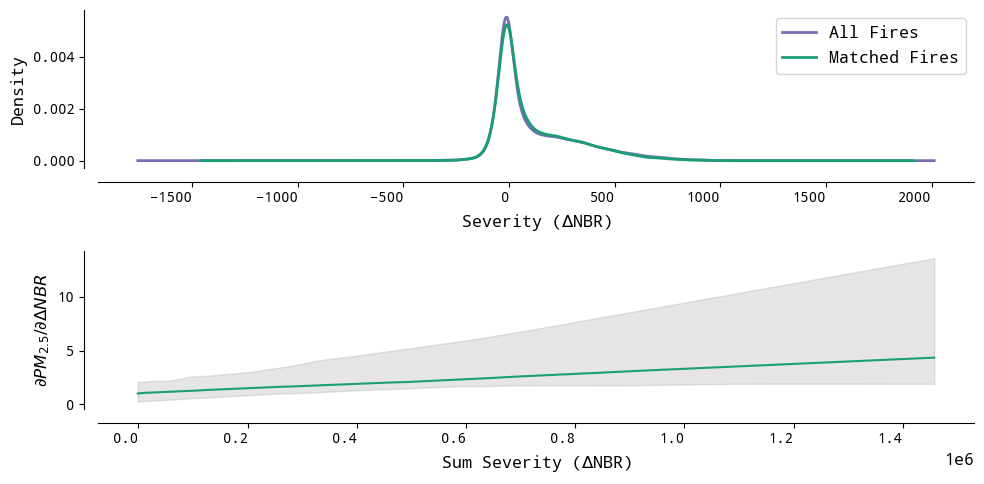

In [ ]:
# Plot the predictions
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
dnbr[dnbr.year > 2006].dnbr.plot.density(ax=ax[0], color="#7570b3", linewidth=2)
dnbr[
    (dnbr.year > 2006)
    & (
        dnbr.event_id.isin(
            smoke_linked[
                smoke_linked.coverage_threshold > 0.6
            ].event_id.tolist()
        )
    )
].dnbr.plot.density(ax=ax[0], color="#1b9e77", linewidth=2)

# Apply template
template_plots(ax[0], xlab="Severity ($\Delta$NBR)", ylab="Density")

# Add a legend for the two density lines
ax[0].legend(["All Fires", "Matched Fires"], loc="upper right")

# Plot marginal effect of severity on emissions
ax[1].fill_between(
    range_severity,
    bounds[0],
    bounds[2],
    alpha=0.2,
    color="gray",
)

# Plot median prediction as a line
ax[1].plot(
    range_severity,
    bounds[1],
    color="#1b9e77",
)

# Apply template
template_plots(
    ax[1],
    xlab="Sum Severity ($\Delta$NBR)",
    ylab="$\partial PM_{2.5} / \partial \Delta NBR$",
)


plt.tight_layout()

# Save plot as a vector graphic
plt.savefig("../figs/severity_emissions_link.png", bbox_inches="tight")

In [223]:
# Make concentration predictions on both observed and simulated data

sim_severity_merge["preds_pm"] = (
    sim_severity_merge.groupby(["sim", "year"])
    .apply(
        lambda df: make_predictions(
            df["sum_sim_dnbr"].values,
            coefs,
            degree=2,
            # controls=df[["total_days", "total_pixels"]].values,
        )
    )
    .reset_index(drop=True)
)

sim_severity["preds_pm"] = (
    sim_severity.groupby(["sim", "year"])
    .apply(
        lambda df: make_predictions(df["sum_sim_dnbr"].values, coefs, degree=2)
    )
    .reset_index(drop=True)
)

sim_severity_preds = (
    sim_severity[sim_severity.sim == 0]
    .groupby("year", as_index=False)
    .apply(
        lambda df: pd.Series(
            {
                "sum_predictions": make_predictions(
                    df["sum_dnbr"].values, coefs, degree=2
                ).sum()
            }
        )
    )
)

# Get the treated-only events from the merged dataset (the one we observe)
treated = sim_severity_merge.groupby(
    "event_id", as_index=False
).sum_sim_dnbr.var()
treated = treated[treated.sum_sim_dnbr > 0].event_id.tolist()


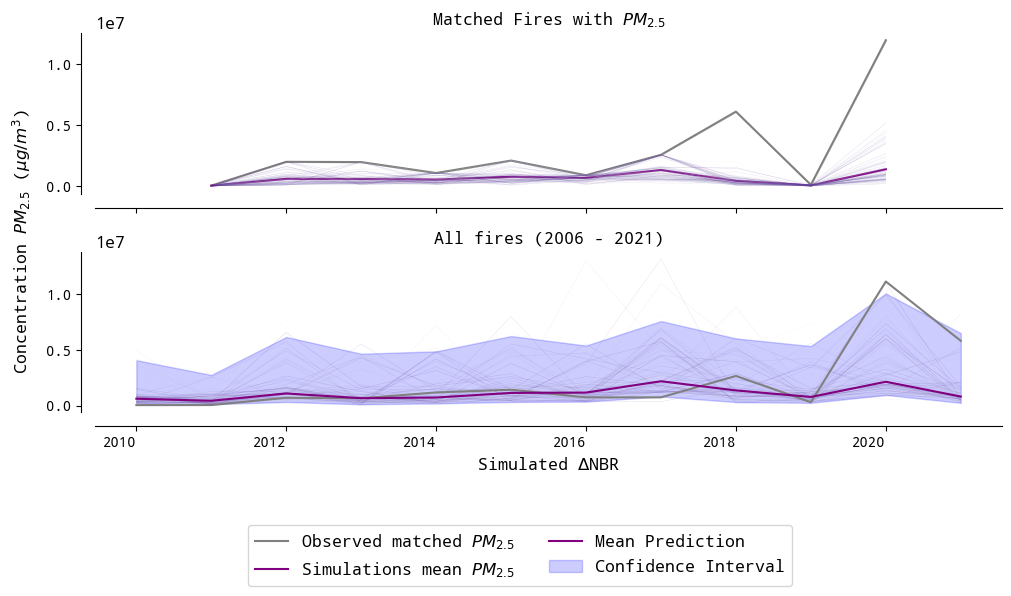

In [224]:
treat_emissions_sample = (
    sim_severity_merge[sim_severity_merge.event_id.isin(treated)]
    .groupby(["sim", "year"], as_index=False)[["preds_pm", "sum_contrib"]]
    .sum()
)

treat_emissions = (
    sim_severity[sim_severity.preds_pm >= 0]
    .groupby(["sim", "year"], as_index=False)[["preds_pm"]]
    .sum()
)

# If prediction is larger than obserbed, asign the observed value
treat_emissions_sample["preds_pm"] = np.where(
    treat_emissions_sample.preds_pm > treat_emissions_sample.sum_contrib,
    treat_emissions_sample.sum_contrib,
    treat_emissions_sample.preds_pm,
)

fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Plot untreated data
sns.lineplot(
    data=treat_emissions_sample,
    x="year",
    y="sum_contrib",
    ax=ax[0],
    label="Observed matched " + r"$PM_{2.5}$",
    legend=False,
    color="gray",
)

# Plot simulations means
sns.lineplot(
    data=treat_emissions_sample.groupby("year", as_index=False).preds_pm.mean(),
    x="year",
    y="preds_pm",
    ax=ax[0],
    label="Simulations mean " + r"$PM_{2.5}$",
    legend=False,
    color="purple",
)

# Plot treated data
sns.lineplot(
    data=treat_emissions_sample,
    x="year",
    y="preds_pm",
    units="sim",
    hue="sim",
    linewidth=0.25,
    ax=ax[0],
    alpha=0.2,
    legend=False,
    palette="Purples",
)

# Apply template
template_plots(
    ax[0],
    xlab="Simulated $\Delta$NBR",
    ylab="",
)

# Plot full sample
sns.lineplot(
    data=treat_emissions,
    x="year",
    y="preds_pm",
    hue="sim",
    units="sim",
    estimator=None,
    linewidth=0.25,
    ax=ax[1],
    alpha=0.2,
    legend=False,
    palette="Purples",
)

sns.lineplot(
    data=sim_severity_preds,
    x="year",
    y="sum_predictions",
    ax=ax[1],
    legend=False,
    color="gray",
)

# Plot the simulations mean and lower/upper bounds
sims_agg = treat_emissions.groupby("year", as_index=False).agg(
    mean_pred=("preds_pm", lambda x: np.quantile(x, 0.5)),
    lower=("preds_pm", lambda x: np.quantile(x, 0.025)),
    upper=("preds_pm", lambda x: np.quantile(x, 0.975)),
)


# Plot the mean predictions with confidence intervals
sns.lineplot(
    data=sims_agg,
    x="year",
    y="mean_pred",
    ax=ax[1],
    legend=False,
    color="purple",
    label="Mean Prediction",
)

# Add the confidence interval manually
ax[1].fill_between(
    sims_agg["year"],
    sims_agg["lower"],
    sims_agg["upper"],
    color="blue",
    alpha=0.2,
    label="Confidence Interval",
)


# Apply template
template_plots(
    ax[1],
    xlab="Simulated $\Delta$NBR",
    ylab="",
)

# Set shared x and y axis labels
fig.text(
    -0.01,
    0.5,
    r"Concentration $PM_{2.5}$ ($\mu g/m^3$)",
    va="center",
    rotation="vertical",
    fontsize=12,
)

# Add subtitles for each subplot
ax[0].set_title("Matched Fires with $PM_{2.5}$", fontsize=12)
ax[1].set_title("All fires (2006 - 2021)", fontsize=12)

# Show the plot
plt.tight_layout()

# Move the legend to the bottom outside the plotting area
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)


# Add log scale to y-axis
# ax[1].set_yscale("log")


In [225]:
def calculate_benefits(
    n_treats, discount_rate, treat_severity, coefs, **kwargs
):
    """ " Calculate benefits from a specific size policy under different discount rates

    This function will calcualte the total benefit of a prescribed policy using
    different parameters, including the size of the treatment, the relationship
    between the emissions and the severity and the discount rate.
    """

    # Get the simulation data merged with the observed dnbr. This dnbr data is
    # expected to be identical to the data we have used throughout the analysis
    # Notice this is a bit of a hack since we are replicating this data by the
    # number of simulations we have (hardcoded to 100).
    df = duckdb.query(f"""
    WITH cross_product AS (
        SELECT d.*, s.sim
        FROM (
            SELECT * FROM '../data/dnbr.parquet'
            WHERE year >= 2010
        ) AS d
        CROSS JOIN (
            SELECT range AS sim
            FROM range(100)
        ) AS s
    ),
    sim AS (
        SELECT lat, lon, year, year_treat, coeff, sim, land_type, grid_id
        FROM '../data/policy_no_spill_{n_treats}/*.parquet'
    )
    SELECT d.grid_id,
        d.year, 
        d.event_id,
        s.year_treat, 
        s.coeff, 
        d.sim, 
        d.dnbr, 
        s.land_type,
        d.dnbr + coalesce(s.coeff, 0) as sim_dnbr
    FROM sim s
    RIGHT JOIN cross_product AS d
    ON s.grid_id = d.grid_id AND s.year = d.year AND s.sim = d.sim
    """)

    # Aggregate results at the year, event and simulation level. We want to
    # calculate the total state emissions using the total emissions from each
    # fire event. This table will hold this for each simulation result.
    sim_severity = duckdb.query("""
    with year_agg as (
    select event_id,
            year,                            
            sim, 
            sum(dnbr) as sum_dnbr,
            sum(sim_dnbr) as sum_sim_dnbr,
    from df
    group by sim, event_id, year
    )
    select * from year_agg
    """).to_df()

    # Translate dnbr results to emission terms (here we have several problems,
    #  mainly lack of controls for the fires we don't observe). We do predictions
    # for the observed dnbr fires and for the simulated ones.
    sim_severity["preds_sim_pm"] = (
        sim_severity.groupby(["sim", "year"])
        .apply(
            lambda df: make_predictions(
                df["sum_sim_dnbr"].values, coefs, **kwargs
            )
        )
        .reset_index(drop=True)
    )

    sim_severity["preds_pm"] = (
        sim_severity.groupby(["sim", "year"])
        .apply(
            lambda df: make_predictions(df["sum_dnbr"].values, coefs, **kwargs)
        )
        .reset_index(drop=True)
    )

    # Calculate benefits for each simulation
    sim_severity["benefit"] = (
        sim_severity["preds_pm"] - sim_severity["preds_sim_pm"]
    )

    # Now calculate the costs of policy emissions! These are the same across all
    # years and simulations.
    policy_cost = make_predictions(
        severity=np.array(np.array([treat_severity] * n_treats).sum()).reshape(
            1,
        ),
        coefs=coefs,
        degree=2,
    )

    # Calculate the net benefits and aggregate to year level
    sim_severity["net_benefit"] = (
        sim_severity["benefit"] / policy_cost.values[0]
    )

    # Remove bad predictions than don't make sense in theory
    sim_severity = sim_severity[
        sim_severity.preds_sim_pm <= sim_severity.preds_pm
    ]

    # Aggregate to state level
    benefits = sim_severity.groupby(["year", "sim"], as_index=False)[
        "net_benefit"
    ].sum()

    # Aggregate to year level
    benefits = benefits.groupby("year", as_index=False).agg(
        mean_pred=("net_benefit", lambda x: np.mean(x)),
        lower=("net_benefit", lambda x: np.quantile(x, 0.025)),
        upper=("net_benefit", lambda x: np.quantile(x, 0.975)),
    )
    benefits["n_treats"] = n_treats

    # Stream of discounts
    years_policy = len(sim_severity.year.unique())
    if isinstance(discount_rate, float):
        discount_rate = np.repeat(discount_rate, years_policy)
        discount_stream = 1 / (1 + discount_rate) ** np.arange(
            1, years_policy + 1
        )

        # Calculate the net present value
        out = pd.DataFrame(
            {
                "npv_mean": (benefits.mean_pred * discount_stream).sum(),
                "npv_q25": (benefits.lower * discount_stream).sum(),
                "npv_q75": (benefits.upper * discount_stream).sum(),
                "n_treats": n_treats,
                "discount_rate": discount_rate,
            },
            index=[0],
        )
    elif isinstance(discount_rate, list):
        out = []
        for dr in discount_rate:
            discount_stream = 1 / ((1 + dr) ** np.arange(1, years_policy + 1))

            # Calculate the net present value
            out.append(
                pd.DataFrame(
                    {
                        "npv_mean": (
                            benefits.mean_pred * discount_stream
                        ).sum(),
                        "npv_q25": (benefits.lower * discount_stream).sum(),
                        "npv_q75": (benefits.upper * discount_stream).sum(),
                        "n_treats": n_treats,
                        "discount_rate": dr,
                    },
                    index=[0],
                )
            )
        out = pd.concat(out)
    else:
        raise ValueError("Discount rate must be a float or a list of floats")

    return out, benefits


In [233]:
total_benefits = []
total_npv = []

for i in range(500, 4500, 500):
    # for i in [50, 100, 150]:
    dr = [i for i in np.arange(0.01, 0.11, 0.01)]
    npv, benefits = calculate_benefits(
        i, dr, treat_severity=100, coefs=coefs, degree=2
    )

    total_benefits.append(benefits)
    total_npv.append(npv)

total_benefits = pd.concat(total_benefits)
total_npv = pd.concat(total_npv)


In [234]:
total_npv

,npv_mean,npv_q25,npv_q75,n_treats,discount_rate
0,88.957223,11.247062,392.512655,500,0.01
0,83.060305,10.396713,367.235192,500,0.02
0,77.687468,9.626090,344.179140,500,0.03
0,72.784271,8.926693,323.114929,500,0.04
0,68.302585,8.291021,303.839530,500,0.05
...,...,...,...,...,...
0,8.603234,0.820468,41.985524,4000,0.06
0,8.080760,0.765842,39.561737,4000,0.07
0,7.602116,0.715905,37.340003,4000,0.08
0,7.162967,0.670193,35.300259,4000,0.09


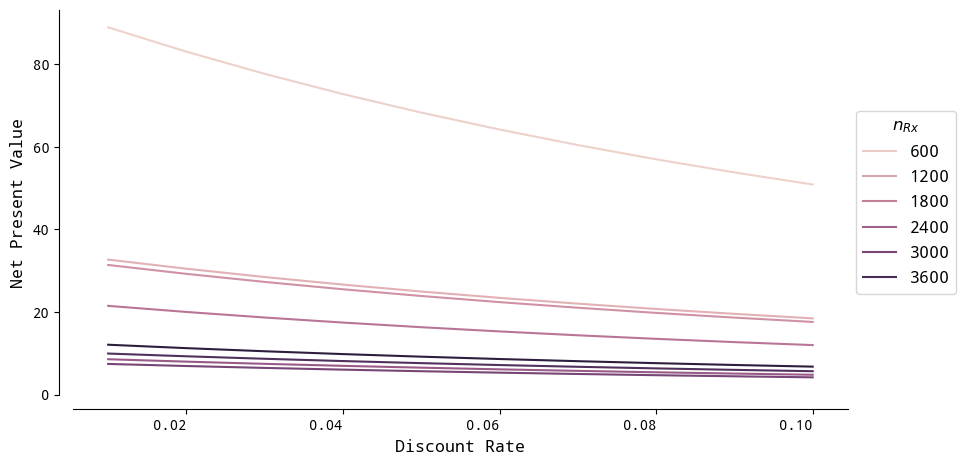

In [238]:
total_npv.sort_values("discount_rate")

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(data=total_npv, x="discount_rate", y="npv_mean", hue="n_treats")


template_plots(ax, xlab="Discount Rate", ylab="Net Present Value")

# Move the legend outside the plot and change the title
plt.legend(title=r"$n_{Rx}$", loc="center left", bbox_to_anchor=(1, 0.5))

# Save plot
plt.savefig("../figs/npv.png", bbox_inches="tight")

In [236]:
total_benefits

,year,mean_pred,lower,upper,n_treats
0,2010,4.591143,0.375144,17.239929,500
1,2011,6.688295,0.180158,43.128698,500
2,2012,8.059376,0.844273,38.209396,500
3,2013,4.767492,0.364187,20.284357,500
4,2014,7.282506,0.544686,33.673355,500
...,...,...,...,...,...
7,2017,1.874434,0.315482,6.274102,4000
8,2018,1.391784,0.174597,6.123039,4000
9,2019,1.049740,0.077421,7.074779,4000
10,2020,1.717319,0.231515,6.727137,4000


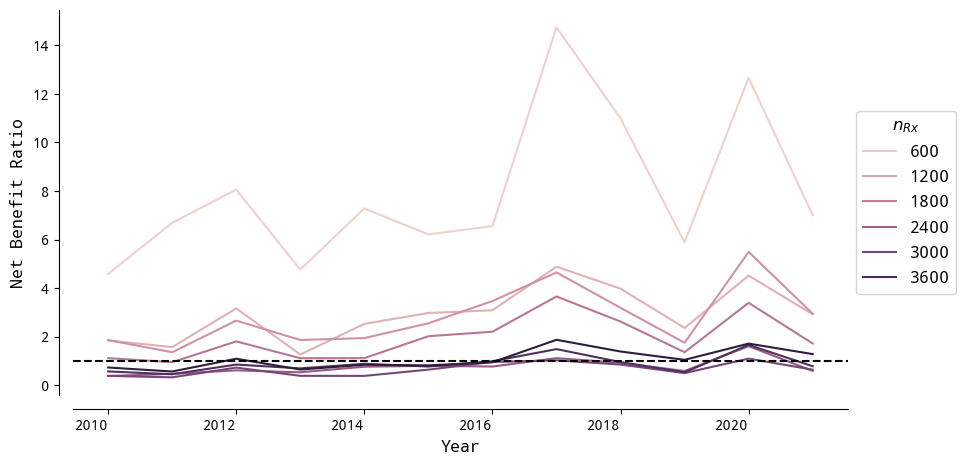

In [239]:
total_benefits

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(
    x="year",
    y="mean_pred",
    ax=ax,
    # data=total_benefits[total_benefits.n_treats == 500],
    data=total_benefits,
    hue="n_treats",
)

template_plots(ax, xlab="Year", ylab="Net Benefit Ratio")

# Add a horizontal line at 0
ax.axhline(1, color="black", linestyle="--")

# Move the legend outside the plot and change the title
plt.legend(title=r"$n_{Rx}$", loc="center left", bbox_to_anchor=(1, 0.5))

# Save plot
plt.savefig("../figs/benefit.png", bbox_inches="tight")

In [85]:
mtbs_ca = mtbs[mtbs.Event_ID.str.startswith("CA")]
rx = mtbs_ca[mtbs_ca.Incid_Type == "Prescribed Fire"]

dnbr_rx = dnbr[dnbr.event_id.isin(rx.Event_ID.unique())]

In [86]:
dnbr_rx.dnbr.mean()

22.195

In [92]:
dnbr_rx.merge(land_type[["grid_id", "land_type"]], on="grid_id").groupby(
    "land_type"
).dnbr.describe()

,count,mean,std,min,25%,50%,75%,max
land_type,,,,,,,,
1.0,126.0,38.241837,167.819916,-515.053406,-29.819010,20.803254,90.685755,678.796692
2.0,766.0,34.789799,83.548225,-388.886139,-10.960777,11.921340,55.087431,721.924133
3.0,310.0,37.746861,89.141502,-249.383270,-9.679750,19.777459,68.989344,408.531586
4.0,41.0,-12.528914,49.369251,-163.440201,-33.576244,-8.002505,10.718513,145.039154
5.0,383.0,-7.035678,75.217155,-331.624451,-40.942759,7.455773,38.993000,229.267059
7.0,62.0,-42.252705,78.034325,-289.586121,-80.579624,-35.111683,6.160237,106.469284
8.0,77.0,39.439327,102.842033,-104.417984,-22.924019,5.116302,50.076530,370.888153
10.0,119.0,-7.776054,108.215225,-497.682220,-43.063108,-7.764656,28.054406,219.282776
11.0,4.0,-54.652267,70.202995,-153.022797,-80.369585,-34.297038,-8.579720,3.007808
